In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame, Series
from dslabs_functions import select_redundant_variables, get_variable_types, encode_cyclic_variables, dummify, mvi_by_filling, evaluate_approach, plot_multibar_chart, determine_outlier_thresholds_for_var, set_chart_labels, study_variance_for_feature_selection, study_redundancy_for_feature_selection, HEIGHT, select_low_variance_variables
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.over_sampling import SMOTE


In [104]:
take_undefined_cpu_time = False
eval_approaches = True

In [105]:
data: DataFrame = read_csv("datasets/class_pos_covid.csv", index_col=None, na_values=None)
vars: dict[str, list] = get_variable_types(data)

binaries: dict[str, int] = {"no": 0, "No": 0, "yes": 1, "Yes": 1, "Female":0, "Male":1}
encoding: dict[str, dict[str, int]] = {}
for bin_col in vars["binary"]:
	encoding[bin_col] = binaries
df: DataFrame = data.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,0,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,0.0,8.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,"Yes, received tetanus shot but not sure what type",0.0,0
1,Alabama,0,Excellent,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,1.60,68.04,26.57,0.0,0.0,0.0,0.0,"No, did not receive any tetanus shot in the pa...",0.0,0
2,Alabama,0,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,1.0,7.0,NaN,0.0,...,1.65,63.50,23.30,0.0,0.0,1.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
3,Alabama,0,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,1.0,9.0,NaN,0.0,...,1.57,53.98,21.77,1.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
4,Alabama,1,Poor,1.0,0.0,Within past year (anytime less than 12 months ...,0.0,7.0,NaN,1.0,...,1.80,84.82,26.08,0.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0


Dorian
state -- population
general health -- ordinal liear
last checkup -- the start of the interval like <1y == 0, >5y == 5
smoker == ecigs -- 00 == nver, 01 == former, 11 == smokes but 
Ruben
race -- dumification
age -- ordinal liear
tetanos -- 00 == no shot, 10 == yes dont know , 11 == yes, knows but not tdap, 12 == yes and is tdap
had diabites -- 00 == no, 10 == yes, 01 == no but is pre diabetic, 11 == yes and before pregancy
teeth -- mid point of interval, 0 teeth = 0, 1-5 == 3, 6+ == 18, all == 32

In [106]:
state : dict[str, int] = {"Virgin Islands": 105870,"Guam": 170534,"Wyoming": 578803,"Vermont": 	645570,
    "District of Columbia": 670050,"Alaska": 732673,"North Dakota": 774948,"South Dakota": 895376,"Delaware": 1003384,
    "Rhode Island": 1095610,"Montana" : 1104271,"Maine": 1372247,"New Hampshire": 1388992,"Hawaii": 1441553,
    "West Virginia": 1782959,"Idaho": 1900923,"Nebraska": 1963692,"New Mexico": 2115877,"Kansas": 2934582,
    "Mississippi": 2949965,"Arkansas": 3025891,"Nevada": 3143991,"Iowa": 3193079,"Puerto Rico": 3263584,
    "Utah": 3337975,"Connecticut": 3605597,"Oklahoma": 3986639,"Oregon": 4246155,"Kentucky": 4509394,
    "Louisiana": 4624047,"Alabama": 5039877,"South Carolina": 5190705,"Minnesota": 5707390,"Colorado": 5812069,
    "Wisconsin": 5895908,"Maryland": 6165129,"Missouri": 6168187,"Indiana": 6805985,"Tennessee": 6975218,
    "Massachusetts": 6984723,"Arizona": 7276316,"Washington": 7738692,"Virginia": 8642274,"New Jersey": 9267130,
    "Michigan" : 10050811,"North Carolina": 10551162,"Georgia": 10799566,"Ohio": 11780017,"Illinois": 12671469,
    "Pennsylvania": 12964056,"New York": 19835913,"Florida": 21781128,"Texas": 29527941,"California": 39237836}

health : dict[str,int] = {"Poor": 0,"Fair": 1,"Good": 2,"Very good": 3,"Excellent": 4}

last : dict[str,int] = {"Within past year (anytime less than 12 months ago)" : 0, 
    "Within past 2 years (1 year but less than 2 years ago)" : 1, 
    'Within past 5 years (2 years but less than 5 years ago)': 2,
    '5 or more years ago': 5}

smoke : dict[str,int] = {"Never smoked": 0,"Former smoker": 1,
    "Current smoker - now smokes some days": 3,
    "Current smoker - now smokes every day": 7}

ecig : dict[str,int] = {"Never used e-cigarettes in my entire life": 0,
    "Not at all (right now)": 1,
    "Use them some days": 3,
    "Use them every day": 7}

encoding['State'] = state
encoding['GeneralHealth'] = health
encoding['LastCheckupTime'] = last
encoding['SmokerStatus'] = smoke
encoding['ECigaretteUsage'] = ecig


df: DataFrame = data.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,"Yes, received tetanus shot but not sure what type",0.0,0
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,1.60,68.04,26.57,0.0,0.0,0.0,0.0,"No, did not receive any tetanus shot in the pa...",0.0,0
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.65,63.50,23.30,0.0,0.0,1.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.57,53.98,21.77,1.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.80,84.82,26.08,0.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0


# Coding RaceEthnicityCategory
The corresponding ethnic distribution in america

In [107]:
""" df = dummify(df, ["RaceEthnicityCategory"])
df.head() """

ethnic_distribution : dict[str,int] = {"White only, Non-Hispanic": 0.593,
    "Hispanic": 0.191,
    "Black only, Non-Hispanic": 0.136,
    "Other race only, Non-Hispanic": 0.079,
	"Multiracial, Non-Hispanic": 0.03
}

encoding['RaceEthnicityCategory'] = ethnic_distribution

df: DataFrame = data.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,"Yes, received tetanus shot but not sure what type",0.0,0
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,1.60,68.04,26.57,0.0,0.0,0.0,0.0,"No, did not receive any tetanus shot in the pa...",0.0,0
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.65,63.50,23.30,0.0,0.0,1.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.57,53.98,21.77,1.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.80,84.82,26.08,0.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0


# Encoding AgeCategory

just ordinal linear encoding nothing special

In [108]:
AgeCategory: dict[str, int] = {"Age 18 to 24":0, "Age 80 or older":12}
for i in range(11):
	AgeCategory[f'Age {i*5 + 25} to {i*5 + 29}'] = i+1
AgeCategory
encoding: dict[str, dict[str, int]] = {"AgeCategory":AgeCategory}
df: DataFrame = df.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,"Yes, received tetanus shot but not sure what type",0.0,0
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,1.60,68.04,26.57,0.0,0.0,0.0,0.0,"No, did not receive any tetanus shot in the pa...",0.0,0
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.65,63.50,23.30,0.0,0.0,1.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.57,53.98,21.77,1.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.80,84.82,26.08,0.0,0.0,0.0,1.0,"No, did not receive any tetanus shot in the pa...",0.0,0


# Encoding TetanusLast10Tdap

tetanos -- 00 == no shot, 10 == yes dont know , 11 == yes, knows but not tdap, 12 == yes and is tdap

In [109]:
TetanusLast10Tdap: dict[str, int] = {
	"Yes, received tetanus shot but not sure what type":2, 
	"No, did not receive any tetanus shot in the past 10 years":0, 
	"Yes, received Tdap":7, 
	"Yes, received tetanus shot, but not Tdap":3
}
encoding: dict[str, dict[str, int]] = {"TetanusLast10Tdap":TetanusLast10Tdap}
df: DataFrame = df.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,2.0,0.0,0
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,1.60,68.04,26.57,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.65,63.50,23.30,0.0,0.0,1.0,1.0,0.0,0.0,0
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.57,53.98,21.77,1.0,0.0,0.0,1.0,0.0,0.0,0
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.80,84.82,26.08,0.0,0.0,0.0,1.0,0.0,0.0,0


# Encoding HadDiabetes
had diabites -- 00 == no, 10 == yes, 01 == no but is pre diabetic, 11 == yes and before pregancy

In [110]:
HadDiabetes: dict[str, int] = {
	"No, pre-diabetes or borderline diabetes":1, 
	"Yes, but only during pregnancy (female)":3, 
	"Yes":2, 
	"No":0
}
encoding: dict[str, dict[str, int]] = {"HadDiabetes":HadDiabetes}
df: DataFrame = df.replace(encoding, inplace=False)
df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,2.0,0.0,0
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,1.60,68.04,26.57,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.65,63.50,23.30,0.0,0.0,1.0,1.0,0.0,0.0,0
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.57,53.98,21.77,1.0,0.0,0.0,1.0,0.0,0.0,0
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.80,84.82,26.08,0.0,0.0,0.0,1.0,0.0,0.0,0


# Encoding RemovedTeeth

encode with the mid point of the interval

i.e. 0 teeth == 0, 1-5 == 2, 6+ == 18, all == 32

In [111]:
RemovedTeeth: dict[str, int] = {"None of them":0, "1 to 5":2, "6 or more, but not all":18, "All":32}
encoding: dict[str, dict[str, int]] = {"RemovedTeeth":RemovedTeeth}
df: DataFrame = df.replace(encoding, inplace=False)
df.head()


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,5039877,0,3.0,0.0,0.0,0.0,0.0,8.0,NaN,0.0,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,2.0,0.0,0
1,5039877,0,4.0,0.0,0.0,NaN,0.0,6.0,NaN,0.0,...,1.60,68.04,26.57,0.0,0.0,0.0,0.0,0.0,0.0,0
2,5039877,0,4.0,0.0,0.0,0.0,1.0,7.0,NaN,0.0,...,1.65,63.50,23.30,0.0,0.0,1.0,1.0,0.0,0.0,0
3,5039877,0,1.0,2.0,0.0,0.0,1.0,9.0,NaN,0.0,...,1.57,53.98,21.77,1.0,0.0,0.0,1.0,0.0,0.0,0
4,5039877,1,0.0,1.0,0.0,0.0,0.0,7.0,NaN,1.0,...,1.80,84.82,26.08,0.0,0.0,0.0,1.0,0.0,0.0,0


In [112]:
def evaluate_approach_and_graph(data, test = None, target="CovidPos", file_tag="class_pos_covid", test_size=0.2, metric="recall"):
	if test is None:
		train, test = train_test_split(data, test_size=test_size, random_state=42)
	else:
		train = data.copy(deep=True)
		test = test.copy(deep=True)

	plt.figure()
	eval: dict[str, list] = evaluate_approach(train, test, target=target, metric=metric)
	plot_multibar_chart(
	    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
	)
	plt.savefig(f"images/{file_tag}_eval.png")
	plt.show()

# Missing Value Imputation
we dont drop cols nor lines with 90% mv because they dont exist

## Approach 1

remove all records with mv

In [113]:
df_mvi_a1: DataFrame = df.dropna(how="any", inplace=False)
""" df_mvi_a1 = df_mvi_a1.drop(df_mvi_a1[df_mvi_a1["RaceEthnicityCategory_nan"] == True].index)
df_mvi_a1 = df_mvi_a1.drop(columns=["RaceEthnicityCategory_nan"]) """
df_mvi_a1

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
252,5039877,0,3.0,4.0,0.0,0.0,1.0,9.0,0.0,0.0,...,1.60,71.67,27.99,0.0,0.0,1.0,1.0,7.0,0.0,0
253,5039877,1,3.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,...,1.78,95.25,30.13,0.0,0.0,1.0,1.0,2.0,0.0,0
255,5039877,0,2.0,3.0,15.0,0.0,1.0,5.0,2.0,0.0,...,1.55,79.38,33.07,0.0,0.0,1.0,1.0,0.0,0.0,0
256,5039877,1,2.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,...,1.85,120.20,34.96,1.0,1.0,1.0,0.0,2.0,0.0,0
257,5039877,0,2.0,3.0,0.0,0.0,1.0,8.0,18.0,0.0,...,1.63,88.00,33.30,0.0,0.0,1.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380918,105870,1,2.0,0.0,0.0,0.0,0.0,6.0,18.0,0.0,...,1.65,65.77,24.13,0.0,0.0,0.0,1.0,3.0,0.0,1
380920,105870,1,1.0,7.0,30.0,0.0,0.0,4.0,0.0,1.0,...,1.88,117.93,33.38,1.0,1.0,0.0,0.0,0.0,0.0,1
380927,105870,0,1.0,0.0,7.0,0.0,1.0,7.0,0.0,0.0,...,1.93,90.72,24.34,0.0,0.0,0.0,0.0,0.0,0.0,1
380928,105870,1,2.0,0.0,15.0,0.0,1.0,7.0,2.0,0.0,...,1.68,83.91,29.86,1.0,1.0,1.0,1.0,2.0,0.0,1


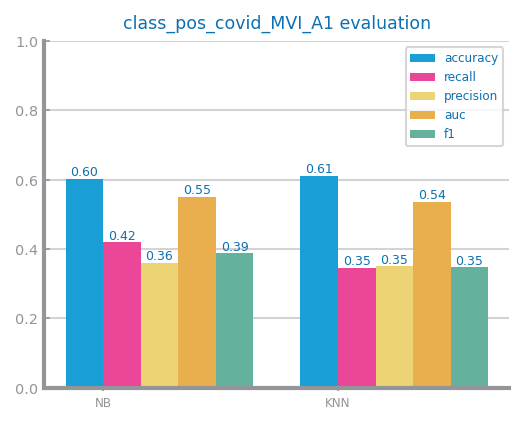

In [114]:
if eval_approaches:
	evaluate_approach_and_graph(df_mvi_a1, file_tag="class_pos_covid_MVI_A1")

## Approach 2
dont remove every record with missing values

In [115]:
df_mvi_a2 = mvi_by_filling(df, strategy="frequent")
""" value_counnts = data["RaceEthnicityCategory"].value_counts()
most_occurences_value = f"RaceEthnicityCategory_{value_counnts.idxmax()}"

df_mvi_a2.loc[df_mvi_a2["RaceEthnicityCategory_nan"] == True, most_occurences_value] = True

df_mvi_a2 = df_mvi_a2.drop(columns=["RaceEthnicityCategory_nan"]) """
df_mvi_a2

,State,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,RemovedTeeth,HadDiabetes,SmokerStatus,ECigaretteUsage,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,5039877.0,3.0,0.0,0.0,0.000000,8.0,4.433718,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5039877.0,4.0,0.0,0.0,0.426368,6.0,4.433718,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5039877.0,4.0,0.0,0.0,0.000000,7.0,4.433718,0.0,3.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,5039877.0,1.0,2.0,0.0,0.000000,9.0,4.433718,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,5039877.0,0.0,1.0,0.0,0.000000,7.0,4.433718,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380927,105870.0,1.0,0.0,7.0,0.000000,7.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
380928,105870.0,2.0,0.0,15.0,0.000000,7.0,2.000000,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
380929,105870.0,2.0,0.0,0.0,1.000000,8.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
380930,105870.0,2.0,0.0,3.0,1.000000,6.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


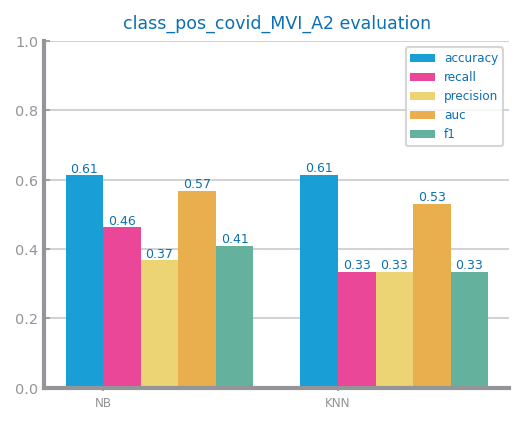

In [116]:
if eval_approaches:
	evaluate_approach_and_graph(df_mvi_a2, file_tag="class_pos_covid_MVI_A2")

# Approach 3

fill all with knn

In [117]:
if take_undefined_cpu_time:
	vars_copy = vars.copy()
	vars_copy["symbolic"].pop(vars_copy["symbolic"].index("RaceEthnicityCategory"))
	vars_copy["binary"].pop(vars_copy["binary"].index("CovidPos"))
	df_mvi_a3_non_numeric = pd.concat([df[vars_copy["binary"]], df[vars_copy["symbolic"]]], axis=1)
	df_mvi_a3_numeric = df[vars_copy["numeric"]]
	df_mvi_a3_non_numeric = mvi_by_filling( df_mvi_a3_non_numeric, strategy="knn")
	df_mvi_a3_numeric = mvi_by_filling(df_mvi_a3_numeric , strategy="frequent")
	df_mvi_a3 = pd.concat([df_mvi_a3_non_numeric, df_mvi_a3_numeric], axis=1)
	
	value_counnts = data["RaceEthnicityCategory"].value_counts()
	most_occurences_value = f"RaceEthnicityCategory_{value_counnts.idxmax()}"
	
	df_mvi_a3.loc[df_mvi_a3["RaceEthnicityCategory_nan"] == True, most_occurences_value] = True
	
	df_mvi_a3 = df_mvi_a3.drop(columns=["RaceEthnicityCategory_nan"])
	df_mvi_a3

In [118]:
if take_undefined_cpu_time and eval_approaches:
	evaluate_approach_and_graph(df_mvi_a3, file_tag="class_pos_covid_MVI_A3")

## Selecting approach

In [119]:
df = df_mvi_a2
df

,State,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,RemovedTeeth,HadDiabetes,SmokerStatus,ECigaretteUsage,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,5039877.0,3.0,0.0,0.0,0.000000,8.0,4.433718,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5039877.0,4.0,0.0,0.0,0.426368,6.0,4.433718,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5039877.0,4.0,0.0,0.0,0.000000,7.0,4.433718,0.0,3.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,5039877.0,1.0,2.0,0.0,0.000000,9.0,4.433718,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,5039877.0,0.0,1.0,0.0,0.000000,7.0,4.433718,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380927,105870.0,1.0,0.0,7.0,0.000000,7.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
380928,105870.0,2.0,0.0,15.0,0.000000,7.0,2.000000,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
380929,105870.0,2.0,0.0,0.0,1.000000,8.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
380930,105870.0,2.0,0.0,3.0,1.000000,6.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


# Outliers Treatment

## Approach 1
Dont treat outliers for weight nor bmi, because that info might be important

truncate the rest

In [120]:
vars_to_treat = vars["numeric"].copy()
vars_to_treat.pop(vars_to_treat.index("WeightInKilograms"))
vars_to_treat.pop(vars_to_treat.index("BMI"))
vars_to_treat


['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters']

In [121]:
def treat_outliers_a1(data: DataFrame, vars_to_treat: list[str]):
    if [] != vars_to_treat:
        df: DataFrame = data.copy(deep=True)
        summary5: DataFrame = data[vars_to_treat].describe()
        for var in vars_to_treat:
            top, bottom = determine_outlier_thresholds_for_var(summary5[var])
            df[var] = df[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        return df
    else:
        print("There are no numeric variables")

In [122]:
df_outliers_a1 = treat_outliers_a1(df, vars_to_treat)
df_outliers_a1

,State,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,RemovedTeeth,HadDiabetes,SmokerStatus,ECigaretteUsage,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,5039877.0,3.0,0.0,0.0,0.000000,8.0,4.433718,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,5039877.0,4.0,0.0,0.0,0.426368,6.0,4.433718,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5039877.0,4.0,0.0,0.0,0.000000,7.0,4.433718,0.0,3.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,5039877.0,1.0,2.0,0.0,0.000000,9.0,4.433718,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,5039877.0,0.0,1.0,0.0,0.000000,7.0,4.433718,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380927,105870.0,1.0,0.0,7.0,0.000000,7.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
380928,105870.0,2.0,0.0,15.0,0.000000,7.0,2.000000,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
380929,105870.0,2.0,0.0,0.0,1.000000,8.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
380930,105870.0,2.0,0.0,3.0,1.000000,6.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


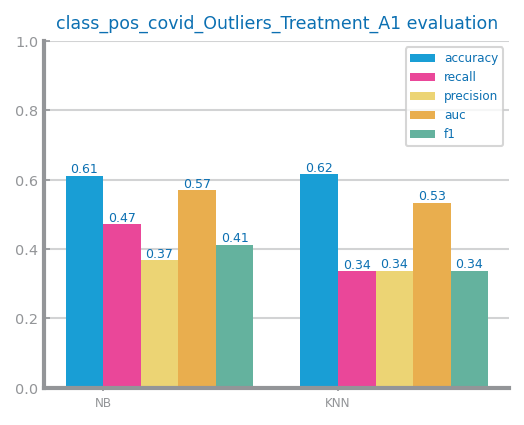

In [123]:
if eval_approaches:
	evaluate_approach_and_graph(df_outliers_a1, file_tag="class_pos_covid_Outliers_Treatment_A1")

## Approach 2
Set every thing as avg

In [124]:
numeric_vars: list[str] = get_variable_types(data)["numeric"]
exclude_vars: list[str] = ["BMI", "WeightInKilograms"]
numeric_vars_to_process: list[str] = [var for var in numeric_vars if var not in exclude_vars]

if [] != numeric_vars_to_process:
    df_outliers_a2: DataFrame = df.copy(deep=True)
    summary5: DataFrame = df[numeric_vars].describe()
    for var in numeric_vars_to_process:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])
        median: float = df[var].median()
        df_outliers_a2[var] =  df_outliers_a2[var].apply(lambda x: median if x > top or x < bottom else x)
    # df2.to_csv(f"data/{file_tag}_replacing_outliers.csv", index=True)
    print("Data after replacing outliers:", df_outliers_a2.shape)
else:
    print("There are no numeric variables")

Data after replacing outliers: (380932, 40)


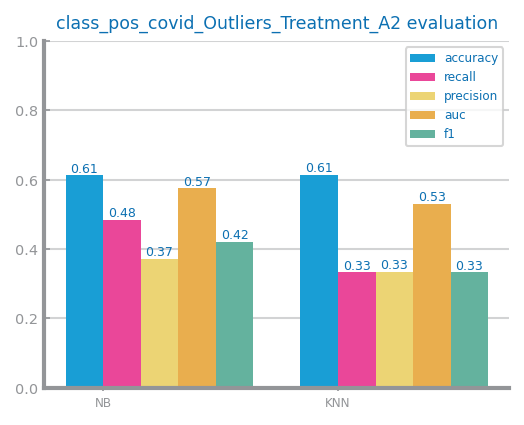

In [125]:
if eval_approaches:
	evaluate_approach_and_graph(df_outliers_a2, file_tag="class_pos_covid_Outliers_Treatment_A2")

## Select best

In [126]:
df = df_outliers_a2

# Scaling

## Scaling Approach 1

In [127]:
df_scaling_a1 = df.copy(deep=True)
target = "CovidPos"
vars: list[str] = df_scaling_a1.columns.to_list()
target_data: Series = df_scaling_a1.pop(target)

transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(
    df_scaling_a1
)
df_scaling_a1 = DataFrame(transf.transform(df_scaling_a1), index=df_scaling_a1.index)
vars.remove(target)
df_scaling_a1.columns = vars
df_scaling_a1[target] = target_data
df_scaling_a1.head()

,State,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,RemovedTeeth,HadDiabetes,SmokerStatus,ECigaretteUsage,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,-0.334706,0.547250,-0.468621,-0.5007,-3.879095e-01,0.993413,0.0,2.245168,-0.504433,0.461095,...,-0.442375,-0.204951,-0.291348,-0.836704,-1.059070,-0.690595,0.944723,-0.788951,-0.212775,0.0
1,-0.334706,1.499017,-0.468621,-0.5007,-1.010080e-16,-1.045694,0.0,-0.444695,-0.504433,-0.366407,...,-0.442375,-0.204951,-0.291348,-0.836704,-1.059070,-0.690595,-1.058512,-0.788951,-0.212775,0.0
2,-0.334706,1.499017,-0.468621,-0.5007,-3.879095e-01,-0.026141,0.0,-0.444695,1.021333,-0.366407,...,-0.442375,-0.204951,-0.291348,1.195166,-1.059070,-0.690595,0.944723,1.267506,-0.212775,0.0
3,-0.334706,-1.356285,0.029645,-0.5007,-3.879095e-01,2.012966,0.0,-0.444695,-0.504433,-0.366407,...,-0.442375,-0.204951,-0.291348,1.195166,0.944225,-0.690595,-1.058512,1.267506,-0.212775,0.0
4,-0.334706,-2.308052,-0.219488,-0.5007,-3.879095e-01,-0.026141,0.0,2.245168,-0.504433,-0.366407,...,-0.442375,-0.204951,-0.291348,-0.836704,-1.059070,-0.690595,-1.058512,1.267506,-0.212775,0.0


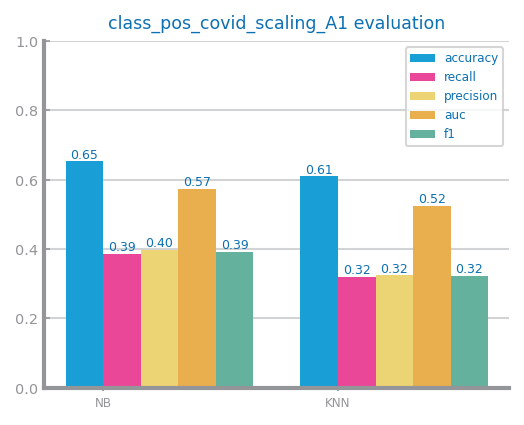

In [128]:
if eval_approaches:
	evaluate_approach_and_graph(df_scaling_a1, file_tag="class_pos_covid_scaling_A1")

## Scaling Approach 2

apply minmax scaling on numeric vars + states

In [129]:
df_scaling_a2 = df.copy(deep=True)
target_data = df_scaling_a2.pop("CovidPos")
df_scaling_a2_columns = df_scaling_a2.columns.to_list()
transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_scaling_a2)
df_scaling_a2 = DataFrame(transf.transform(df_scaling_a2), index=data.index)
df_scaling_a2.columns = df_scaling_a2_columns
df_scaling_a2["CovidPos"] = target_data
df_scaling_a2

,State,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,RemovedTeeth,HadDiabetes,SmokerStatus,ECigaretteUsage,...,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,ChestScan,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,0.126086,0.75,0.000000,0.000000,0.000000,0.75,0.138554,0.666667,0.000000,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.126086,1.00,0.000000,0.000000,0.085274,0.25,0.138554,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.126086,1.00,0.000000,0.000000,0.000000,0.50,0.138554,0.000000,0.428571,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.126086,0.25,0.095238,0.000000,0.000000,1.00,0.138554,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.126086,0.00,0.047619,0.000000,0.000000,0.50,0.138554,0.666667,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380927,0.000000,0.25,0.000000,0.333333,0.000000,0.50,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
380928,0.000000,0.50,0.000000,0.714286,0.000000,0.50,0.062500,0.666667,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
380929,0.000000,0.50,0.000000,0.000000,0.200000,0.75,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
380930,0.000000,0.50,0.000000,0.142857,0.200000,0.25,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0


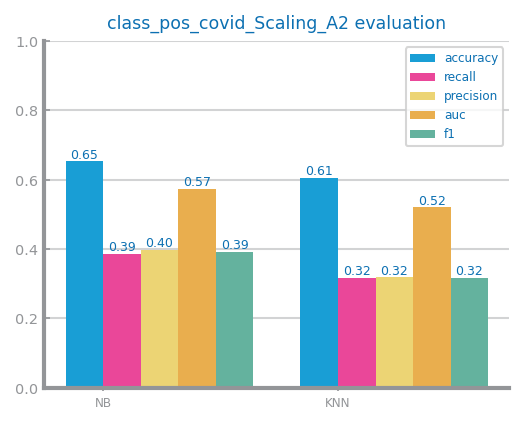

In [130]:
if eval_approaches:
	evaluate_approach_and_graph(df_scaling_a2, file_tag="class_pos_covid_Scaling_A2")

## Selecting best
only selected A2 because the functions of feature selection doesnt work

In [131]:
df = df_scaling_a2

# Feature Selection

In [132]:
if take_undefined_cpu_time:
    train, test = train_test_split(df, test_size=0.2)
    plt.figure(figsize=(2 * HEIGHT, HEIGHT))
    results, options = study_variance_for_feature_selection(
        train,
        test,
        target="CovidPos",
        max_threshold=0.1,
        lag=0.01,
        metric="recall",
        file_tag="pos-covid-feature-selection",
    )
    plt.show()

In [133]:
if take_undefined_cpu_time:
    plt.figure(figsize=(2 * HEIGHT, HEIGHT))
    results, options = study_redundancy_for_feature_selection(
        train,
        test,
        target="CovidPos",
        min_threshold=0.25,
        lag=0.05,
        metric="recall",
        file_tag="pos-covid-feature-selection",
    )
    plt.show()

## Feature Selection Approach 1

In [134]:
vars2drop: list[str] = select_low_variance_variables(df, 0.03, target=target)
vars2drop

['ECigaretteUsage', 'WeightInKilograms', 'BMI']

In [135]:
redundantVars = select_redundant_variables(df, 0.8, target=target)
redundantVars

[]

In [136]:
for var in redundantVars:
	if var in vars2drop:
		continue
	vars2drop.append(var)
vars2drop

['ECigaretteUsage', 'WeightInKilograms', 'BMI']

In [137]:
df_feature_select_a1 = df.copy(deep=True)

df_feature_select_a1 = df_feature_select_a1.drop(vars2drop, axis=1)

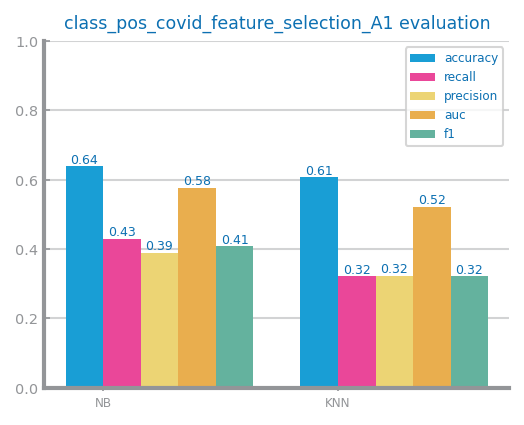

In [138]:
if eval_approaches:
	evaluate_approach_and_graph(df_feature_select_a1, file_tag="class_pos_covid_feature_selection_A1")

## Feature Selection Approach 2

In [139]:
vars2drop: list[str] = select_low_variance_variables(df, 0.05, target=target)
vars2drop

['State',
 'PhysicalHealthDays',
 'MentalHealthDays',
 'LastCheckupTime',
 'ECigaretteUsage',
 'WeightInKilograms',
 'BMI',
 'HadStroke',
 'HadKidneyDisease',
 'DifficultyDressingBathing',
 'HighRiskLastYear']

In [140]:
redundantVars = select_redundant_variables(df, 0.8, target=target)
redundantVars

[]

In [141]:
for var in redundantVars:
	if var in vars2drop:
		continue
	vars2drop.append(var)

In [142]:
df_feature_select_a2 = df.copy()

df_feature_select_a2 = df_feature_select_a2.drop(vars2drop, axis=1)

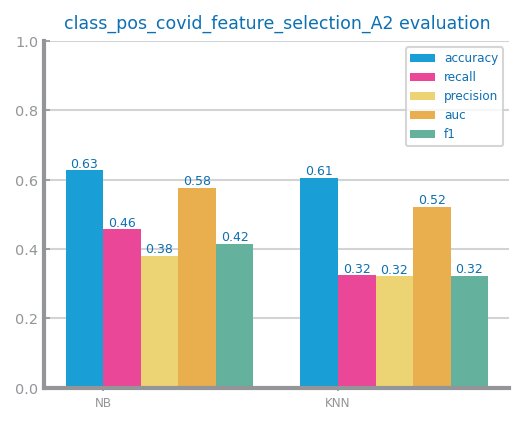

In [143]:
if eval_approaches:
	evaluate_approach_and_graph(df_feature_select_a2, file_tag="class_pos_covid_feature_selection_A2")

## Feature Selection Approach 3

In [144]:
vars2drop: list[str] = select_low_variance_variables(df, 0.07, target=target)
vars2drop

['State',
 'GeneralHealth',
 'PhysicalHealthDays',
 'MentalHealthDays',
 'LastCheckupTime',
 'SleepHours',
 'HadDiabetes',
 'ECigaretteUsage',
 'HeightInMeters',
 'WeightInKilograms',
 'BMI',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadKidneyDisease',
 'BlindOrVisionDifficulty',
 'DifficultyDressingBathing',
 'HighRiskLastYear']

In [145]:
redundantVars = select_redundant_variables(df, 0.8, target=target)
redundantVars

[]

In [146]:
for var in redundantVars:
	if var in vars2drop:
		continue
	vars2drop.append(var)

In [147]:
df_feature_select_a3 = df.copy()

df_feature_select_a3 = df_feature_select_a3.drop(vars2drop, axis=1)

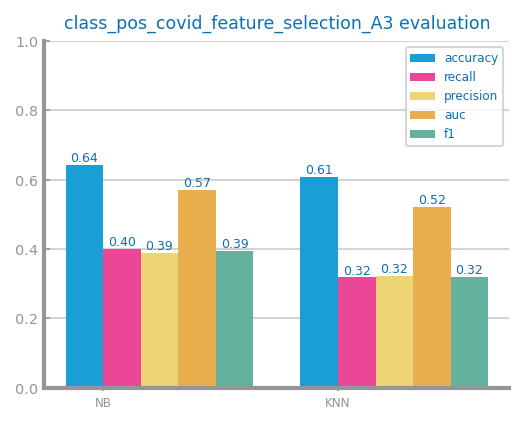

In [148]:
if eval_approaches:
	evaluate_approach_and_graph(df_feature_select_a3, file_tag="class_pos_covid_feature_selection_A3")

## Selection

In [149]:
df = df_feature_select_a2

# Data Separation

In [150]:
df, df_test = train_test_split(df, test_size=0.2)

# Balancing

In [151]:
positive_class = 1
negative_class = 0

## Approach 1

In [152]:
df_positives: Series = df[df[target] == 1]
df_negatives: Series = df[df[target] == 0]

df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = pd.concat([df_positives, df_neg_sample], axis=0)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 1 : 88775
Majority class= 0 : 88775
Proportion: 1.0 : 1


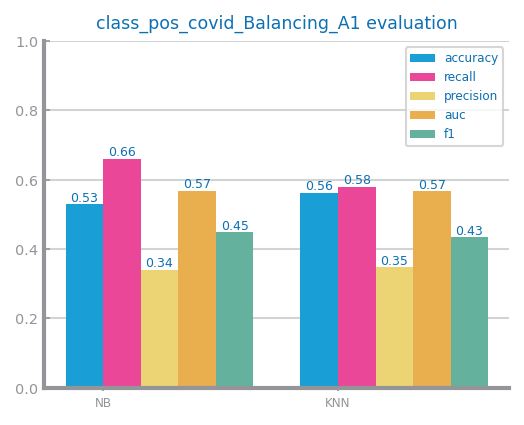

In [153]:
if eval_approaches:
	evaluate_approach_and_graph(df_under, test=df_test, file_tag="class_pos_covid_Balancing_A1")

## Approach 2

In [154]:
df_positives: Series = df[df[target] == 1]
df_negatives: Series = df[df[target] == 0]
df_pos_sample: DataFrame = DataFrame(
    df_positives.sample(len(df_negatives), replace=True)
)
df_over: DataFrame = pd.concat([df_pos_sample, df_negatives], axis=0)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")

Minority class= 1 : 215970
Majority class= 0 : 215970
Proportion: 1.0 : 1


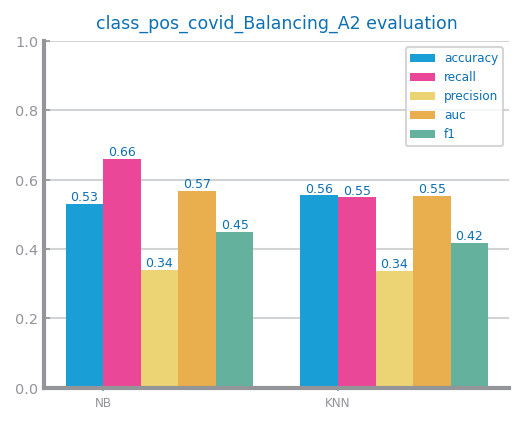

In [155]:
if eval_approaches:
	evaluate_approach_and_graph(df_over, test=df_test, file_tag="class_pos_covid_Balancing_A2")

## Approach 3

In [156]:
target = "CovidPos"

df_positives: Series = df[df[target] == 1]
df_negatives: Series = df[df[target] == 0]
RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = df.pop(target).values
X: np.ndarray = df.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = pd.concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(df.columns) + [target]

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= 1 : 215970
Majority class= 0 : 215970
Proportion: 1.0 : 1
(431940, 29)


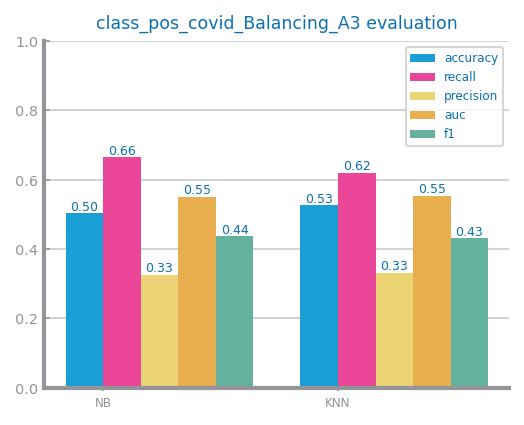

In [158]:
if eval_approaches:
	evaluate_approach_and_graph(df_smote, test=df_test, file_tag="class_pos_covid_Balancing_A3")

## Selecting best

In [160]:
df = df_over

# Saving Datasets

In [161]:
df.to_csv("datasets/class_pos_covid_train.csv")
df_test.to_csv("datasets/class_pos_covid_test.csv")